In [106]:
#import packages
import pandas as pd
import numpy as np
from numpy import cumsum
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
import joblib

In [107]:
#import data file & preview data 
df = pd.read_csv('/Users/Amanda.Hartzler/Desktop/Data_Analytics_Masters/D213/Task 1/teleco_time_series.csv')
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [108]:
#determine column names, non-null values, & data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [109]:
#look at summary statistics for each column 
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [110]:
#Check for duplicated values
print(df.duplicated())
print(df.duplicated().sum())

0      False
1      False
2      False
3      False
4      False
       ...  
726    False
727    False
728    False
729    False
730    False
Length: 731, dtype: bool
0


In [111]:
#(Elleh, 2022)
#Convert Day column to a Date
df['Date'] = (pd.date_range(start=datetime(2019, 1, 1), periods=df.shape[0], freq='24H'))

#Set the date as an index 
df.set_index('Date', inplace=True)
df

,Day,Revenue
Date,,
2019-01-01,1,0.000000
2019-01-02,2,0.000793
2019-01-03,3,0.825542
2019-01-04,4,0.320332
2019-01-05,5,1.082554
...,...,...
2020-12-27,727,16.931559
2020-12-28,728,17.490666
2020-12-29,729,16.803638


In [112]:
#Drop Day column
df.drop(labels = 'Day', axis=1, inplace=True)
df.head()

,Revenue
Date,
2019-01-01,0.000000
2019-01-02,0.000793
2019-01-03,0.825542
2019-01-04,0.320332
2019-01-05,1.082554


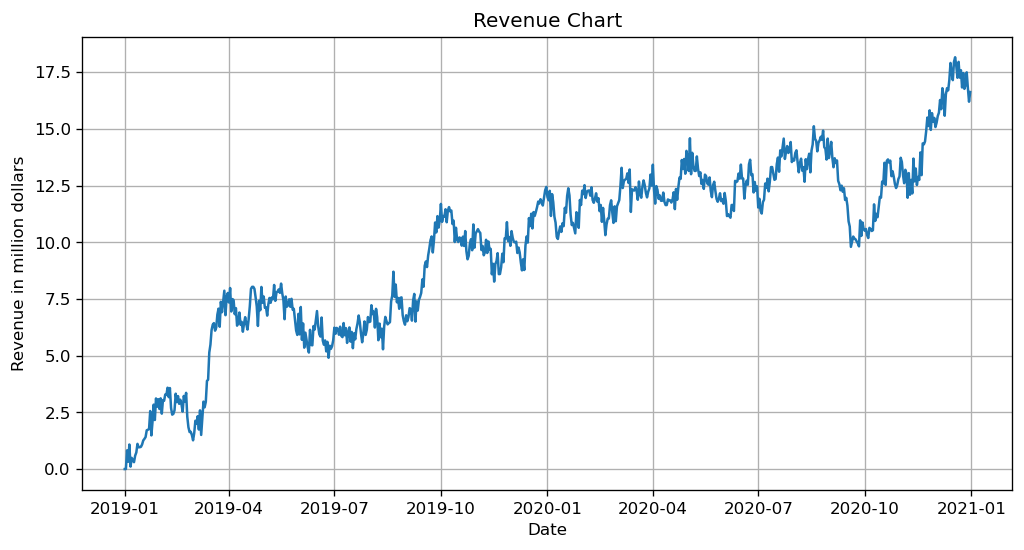

In [113]:
#(Elleh, 2022)
#Visualize the data 
plt.figure(figsize=(10,5))
plt.plot(df.Revenue)
plt.title('Revenue Chart')
plt.xlabel('Date')
plt.ylabel('Revenue in million dollars')
plt.grid(True)
plt.show()

In [114]:
#(Elleh, 2022)
#Use Augmented Dickey-Fuller test to check for stationarity 
result = adfuller(df['Revenue'])
print('Test Statistics: ', result[0])
print('p-value: ', result[1])
print('Critical Values: ', result[4])

Test Statistics:  -1.9246121573101835
p-value:  0.3205728150793964
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [115]:
#Null Hypothesis H0: Time series is non-stationary
#Alternative Hypothesis H1: Time series is stationary 
#Since p-value is not <= 0.05, fail to reject the null hypothesis, therefore, the time series is non-stationary 

In [116]:
#(Elleh, 2022)
#Make the time series stationary using differencing
df_stationary = df.diff().dropna()
df_stationary.head()

,Revenue
Date,
2019-01-02,0.000793
2019-01-03,0.824749
2019-01-04,-0.505210
2019-01-05,0.762222
2019-01-06,-0.974900


In [117]:
#(Elleh, 2022)
#Re-test for stationarity 
result = adfuller(df_stationary['Revenue'])
print('Test Statistics: ', result[0])
print('p-value: ', result[1])
print('Critical Values: ', result[4])

Test Statistics:  -44.87452719387599
p-value:  0.0
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [118]:
#Null Hypothesis H0: Time series is non-stationary
#Alternative Hypothesis H1: Time series is stationary 
#Since p-value is <= 0.05, reject the null hypothesis, therefore, the time series is stationary 

In [119]:
#Copy of cleaned dataset
df.to_csv('/Users/Amanda.Hartzler/Desktop/D213_PA_Task1.csv')

In [120]:
#(Elleh, 2022)
#Split into train and test datasets
X_train = df_stationary.loc[:'2020-08-08']
X_test = df_stationary.loc['2020-08-08':]

print('X_train Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_train Shape (585, 1)
X_test Shape (146, 1)


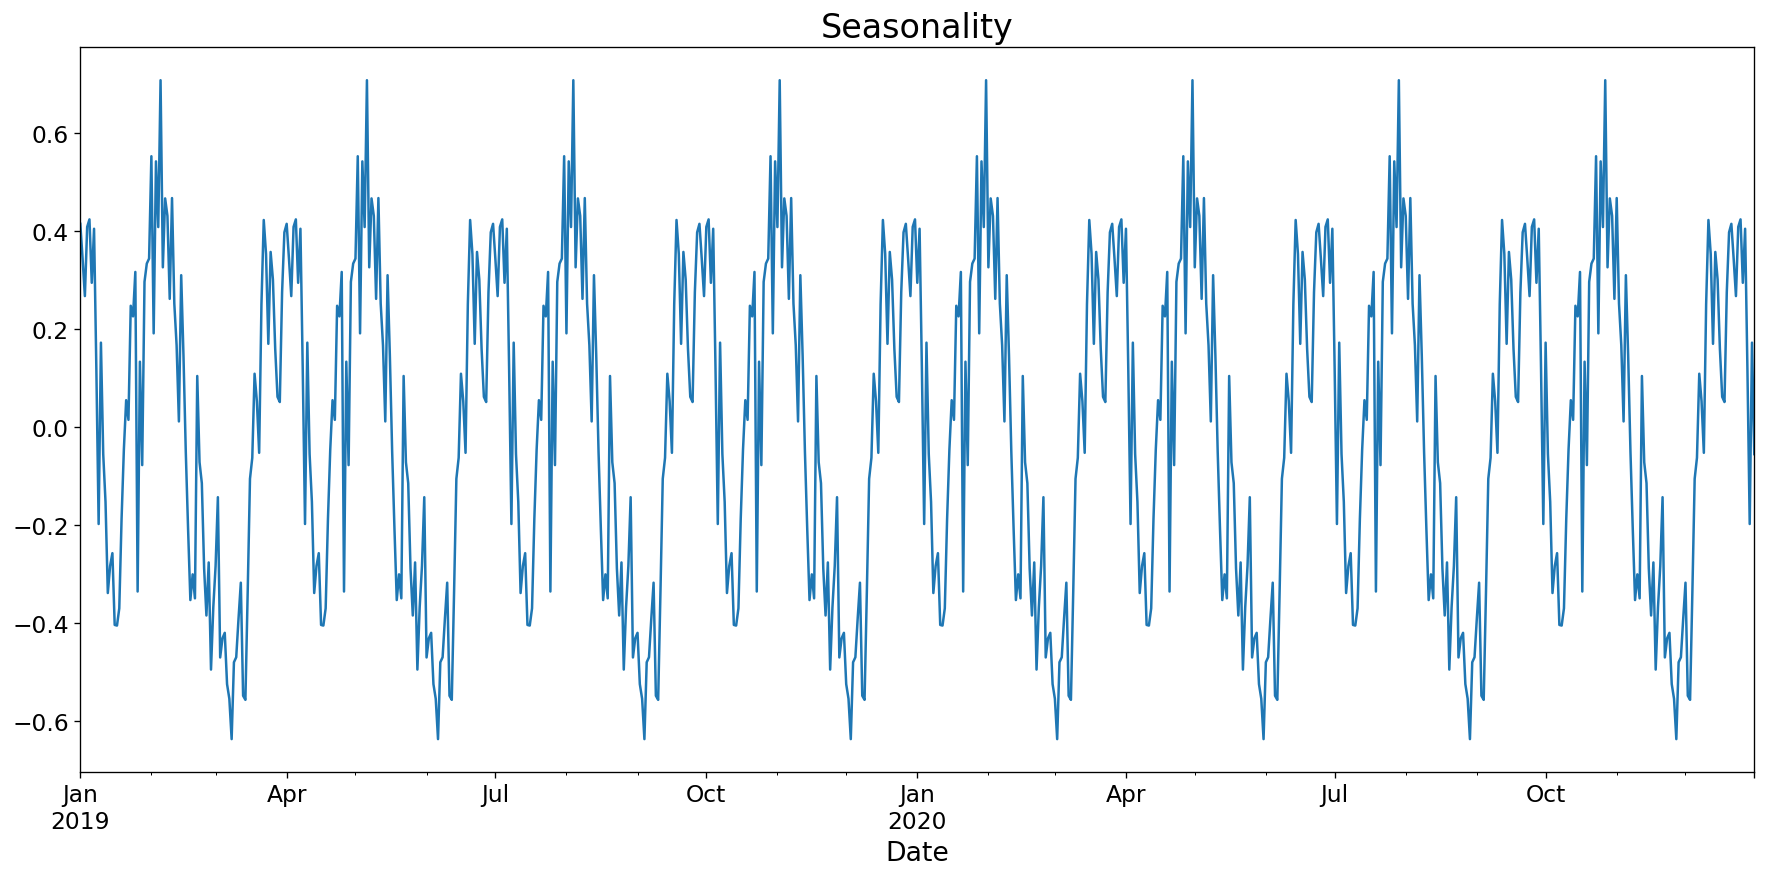

In [121]:
#Plot seasonality 
rcParams['figure.figsize'] = (18, 8)
plt.title('Seasonality', fontsize=20)
plt.xlabel('Date', fontsize=16)
fig = decomp.seasonal.plot(fontsize=14)
plt.show()
#(Larrosa, 2021)

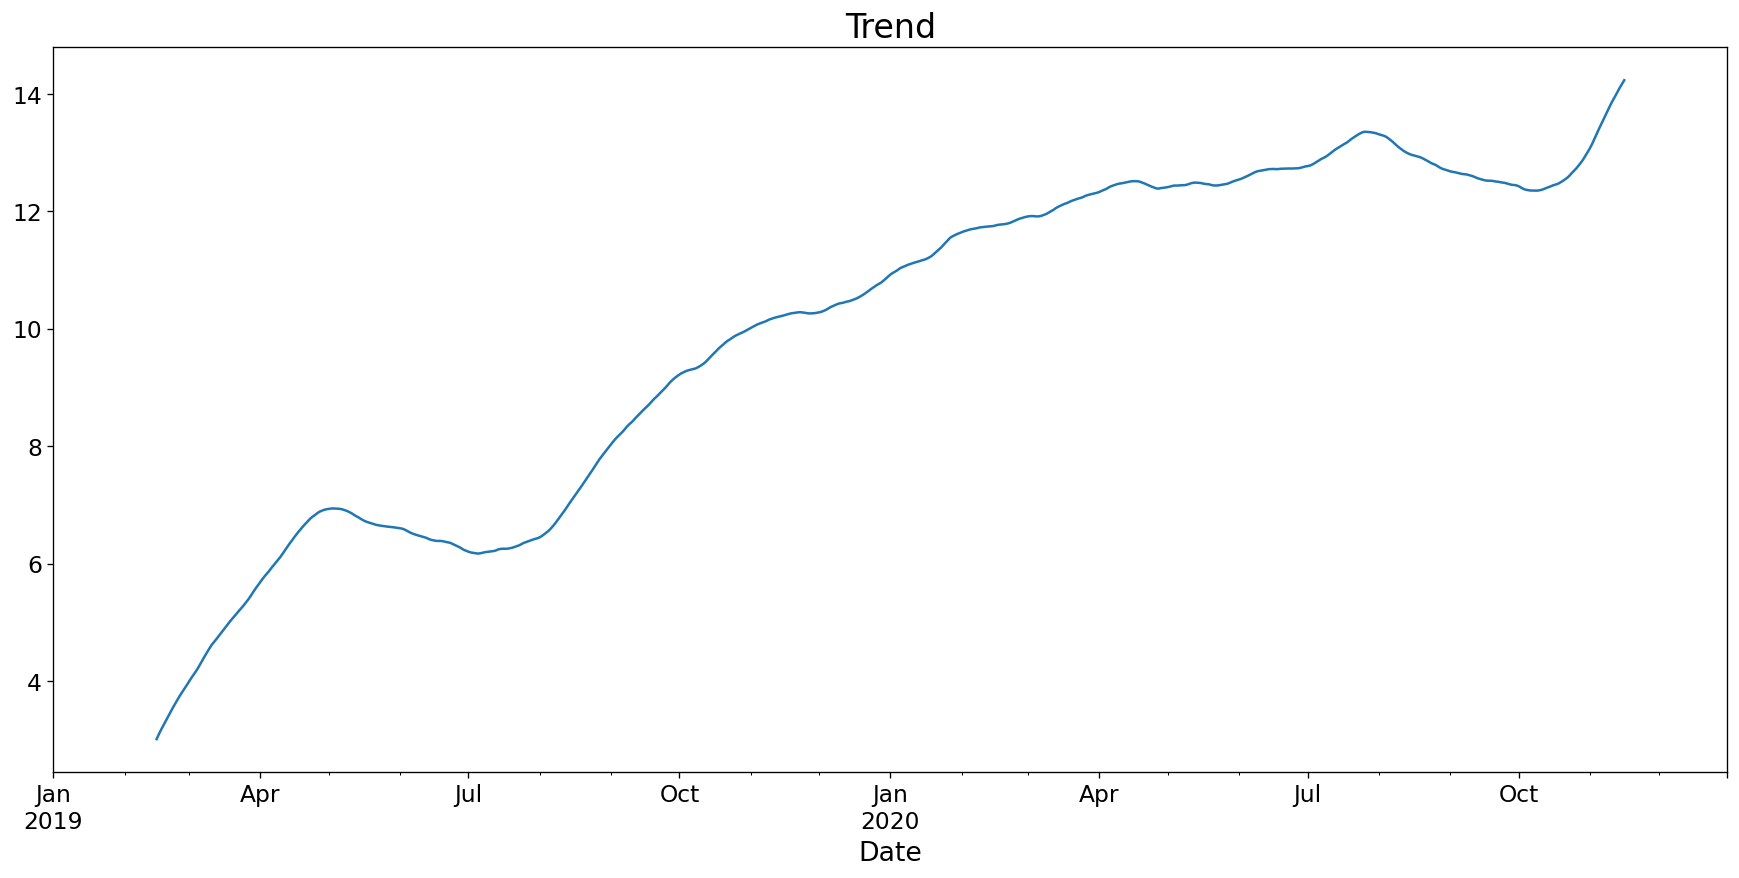

In [122]:
#Plot the trend 
rcParams['figure.figsize'] = (18, 8)
plt.title('Trend', fontsize=20)
plt.xlabel('Date', fontsize=16)
fig = decomp.trend.plot(fontsize=14)
plt.show()
#(Larrosa, 2021)

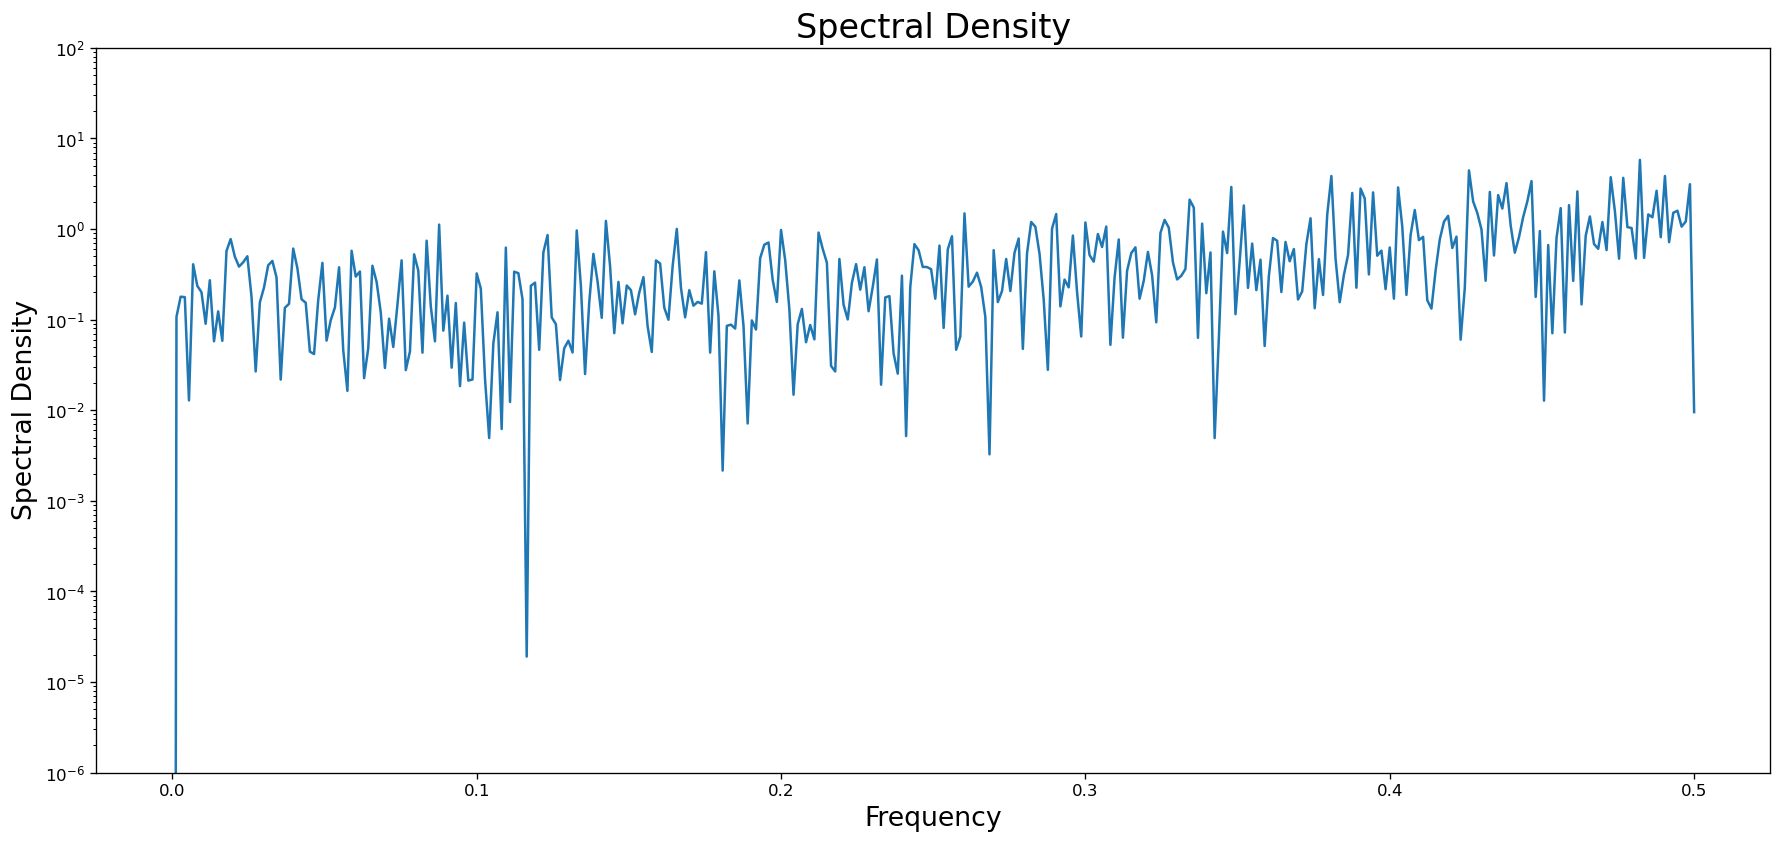

In [123]:
#Spectral Density (Elleh, 2022)
f, PXX_den = signal.periodogram(df_stationary['Revenue'])
plt.semilogy(f, PXX_den)
plt.ylim([1e-6, 1e2])
plt.title('Spectral Density', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Spectral Density', fontsize=16)
plt.show()

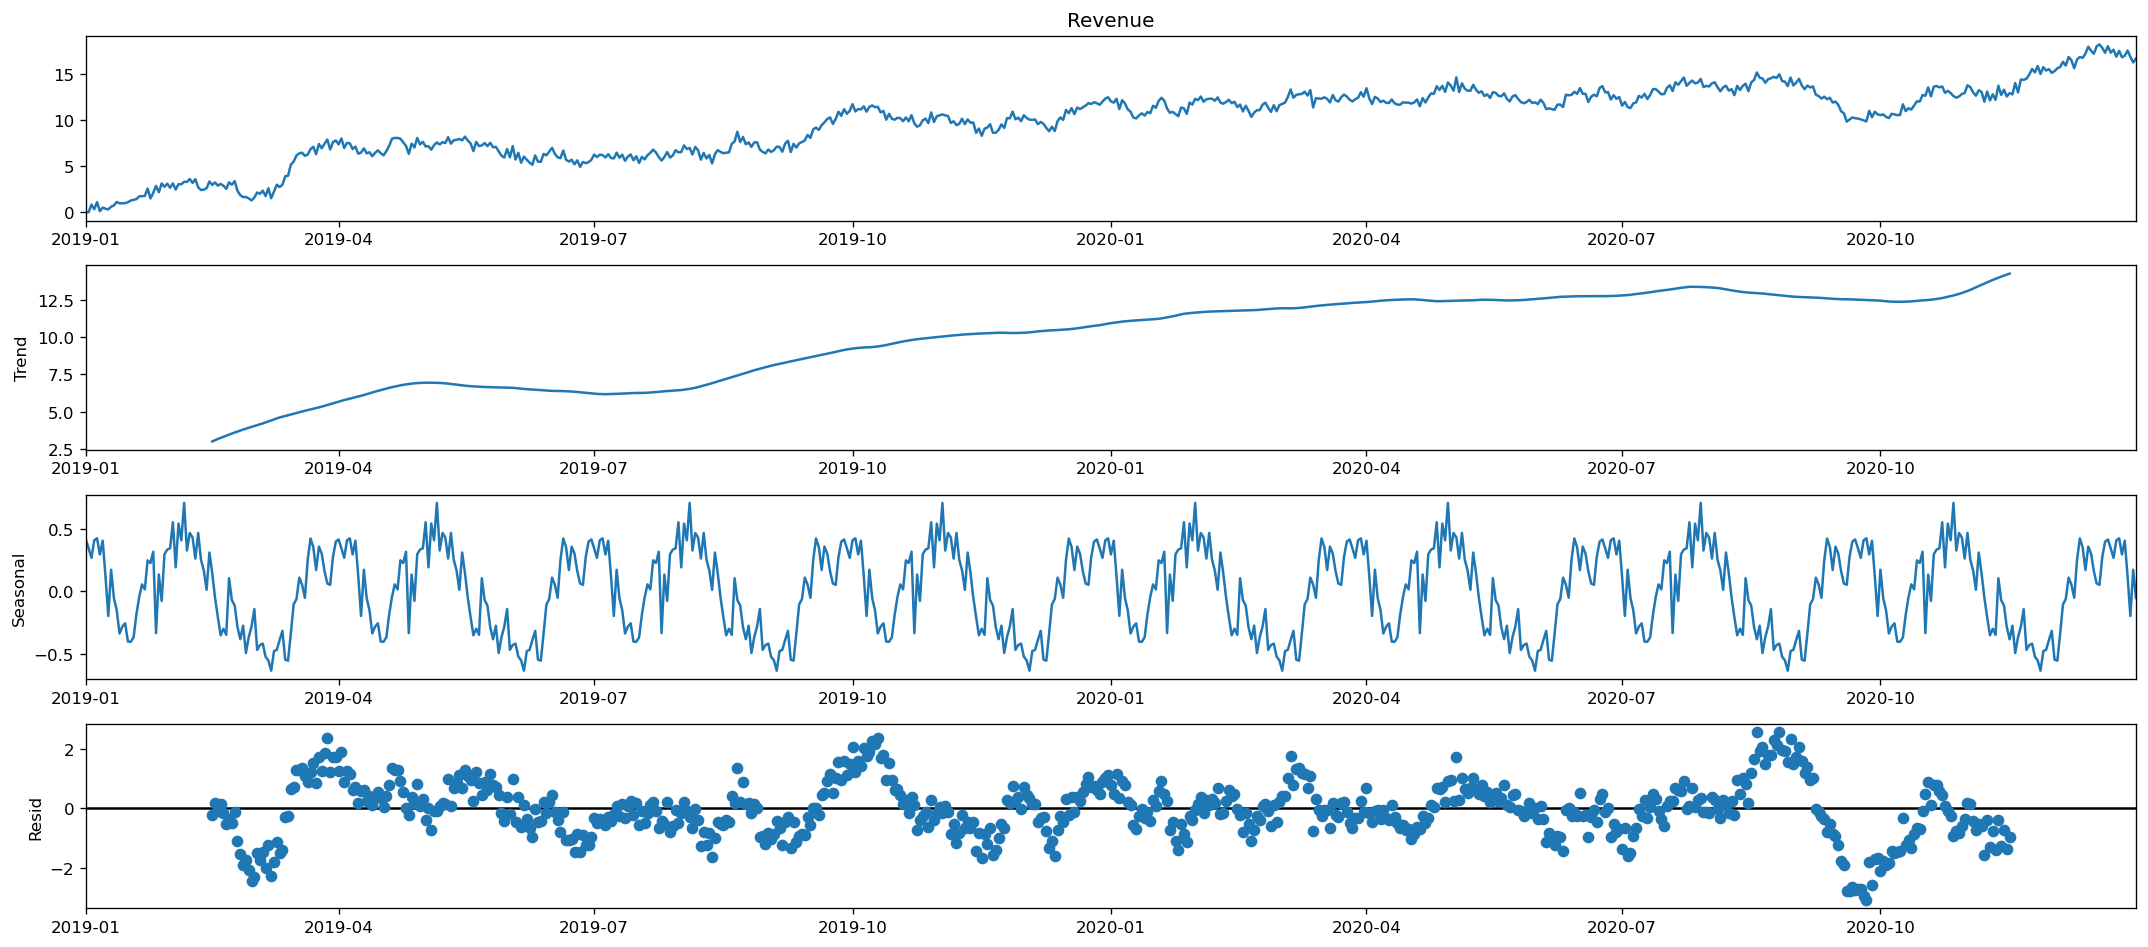

In [124]:
#Perform Decomposition (Elleh, 2022)
decomp = seasonal_decompose(df['Revenue'], period=90)

#Plot decomposition (Larrosa, 2021)

from pylab import rcParams
rcParams['figure.figsize'] = (18, 8)
fig = decomp.plot()
plt.show()


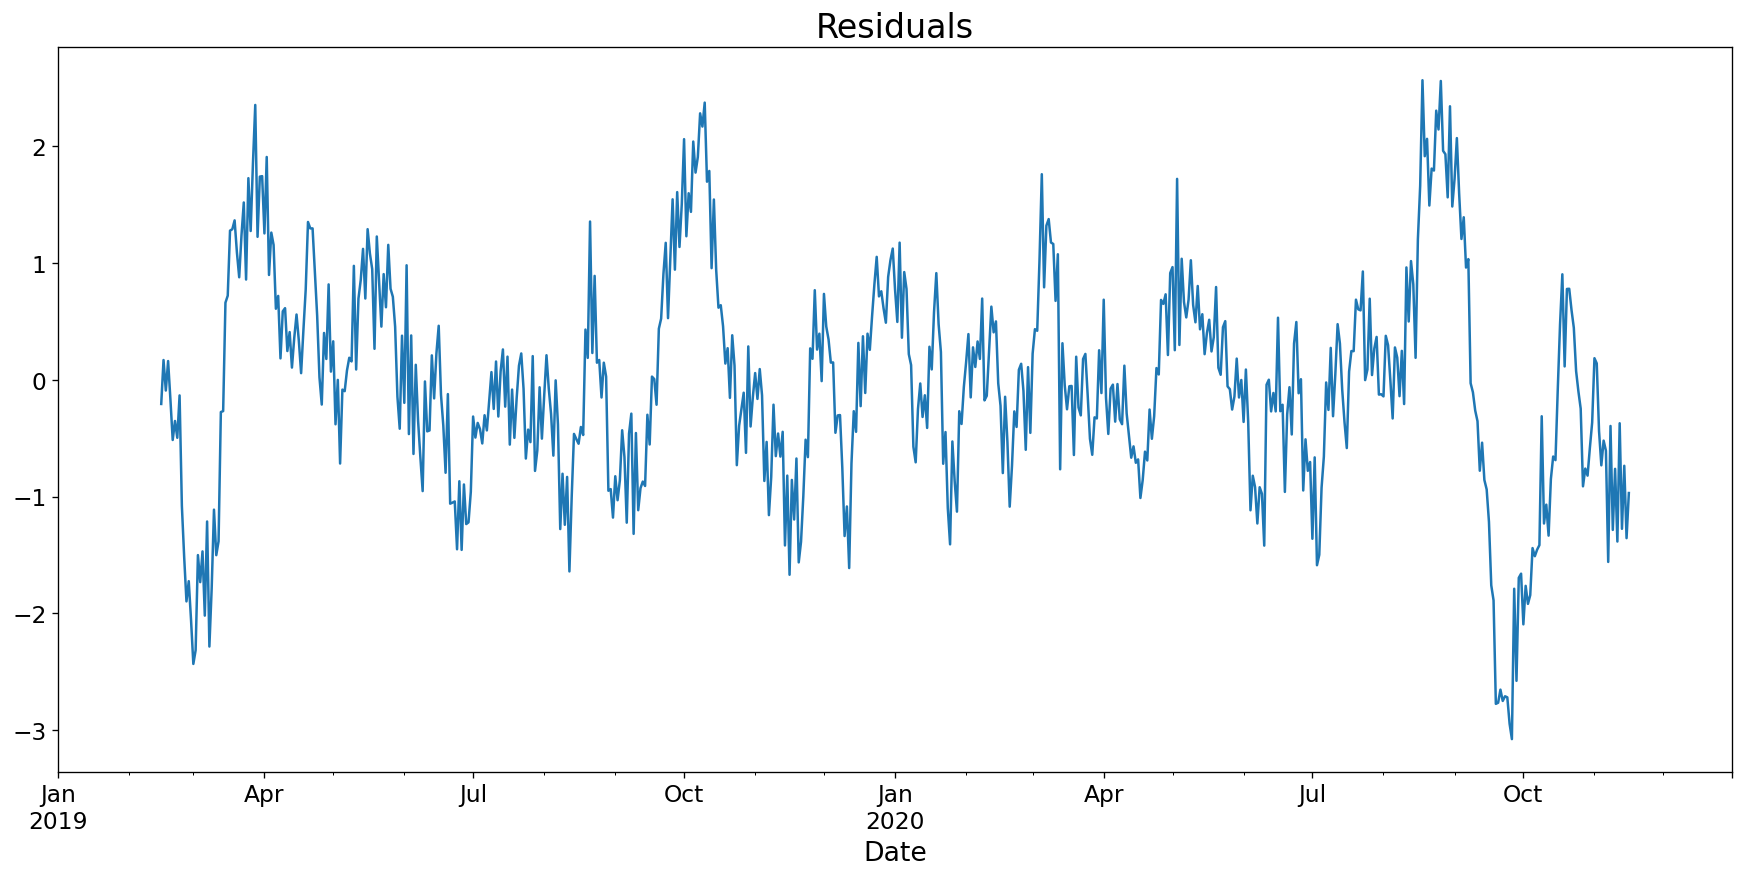

In [125]:
#Plot residuals
rcParams['figure.figsize'] = (18, 8)
plt.title('Residuals', fontsize=20)
plt.xlabel('Date', fontsize=16)
fig = decomp.resid.plot(fontsize=14)
plt.show()
#(Larrosa, 2021)

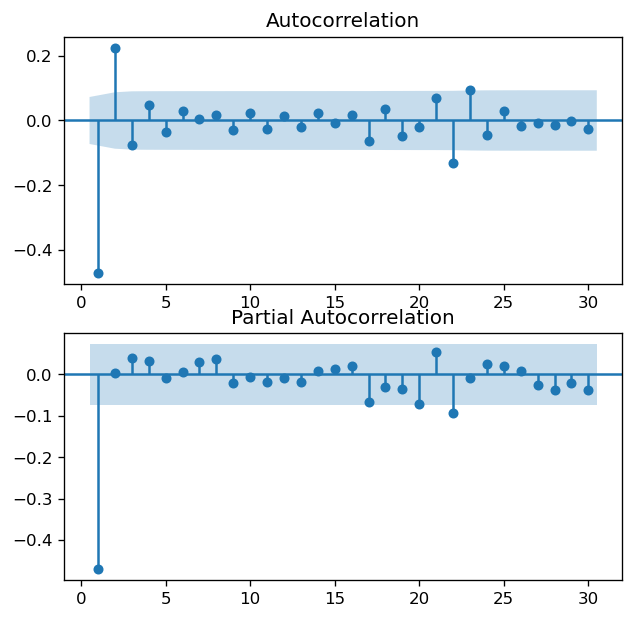

In [126]:
#(Elleh, 2022)
#Autocorrelation plots (ACF & PACF)

#Create figure 
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6))

#Plot the ACF of the dataframe 
plot_acf(df_stationary, lags=30, zero=False, ax=ax1)

#Plot the PACF of the dataframe
plot_pacf(df_stationary, lags=30, zero=False, ax=ax2)
plt.show()

In [127]:
#PACF cuts off after lag p(1) and ACF trails off. Indicating AR(1) model.

In [128]:
#Pick best order by Akaike Information Criterion (AIC). Smaller value for AIC is preffered best_aic = np.inf (Elleh, 2022)
best_aic = np.inf 
best_order = None
best_md1 = None
rng = range(3)
for p in rng: #loop over p values
    for q in rng: #loop over q values 
        try:
            #create and fit ARMA(p, q) model
            model = SARIMAX(df, order=(p, 1, q), trends='c')
            results = model.fit()
            tmp_aic = results.aic
            print(p, q, results.aic, results.bic)
            if tmp_aic < best_aic: 
                best_aic = tmp_aic
                best_order = (p, q)
                best_md1 = tmp_md1
            #print order and results
        except: 
            print(p, q, None, None)
            
print('\nBest AIC: {:6.5f} | order:{}'.format(best_aic, best_order))

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93529D-01    |proj g|=  2.52079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2     13      1     0     0   3.901D-05   7.935D-01
  F =  0.79352864990324123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 0 1162.1388861585388 1166.731930692681
0 0 None None
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.70558D-01    |proj g|=  2.64248D-03

At iterate   15    f=  6.70266D-01    |proj g|=  1.97585D-02

At iterate   20    f=  6.69567D-01    |proj g|=  2.12829D-03

At iterate   25    f=  6.69532D-01    |proj g|=  2.76242D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     29      1     0     0   2.762D-06   6.695D-01
  F =  0.66953229112545254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 986.8562096254116 1005.2283877619814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 var

 This problem is unconstrained.


In [129]:
#Find the best model using Auto_ARIMA (includes seasonality) (Elleh, 2022)
model = pm.auto_arima(df, 
                     seasonal=True, m=90, 
                     d=1, D=1,
                     start_p=1, start_q=1, 
                     max_p=2, max_q=2, 
                     max_P=2, max_Q=2, 
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[90]             : AIC=inf, Time=145.63 sec
 ARIMA(0,1,0)(0,1,0)[90]             : AIC=1433.753, Time=2.88 sec
 ARIMA(1,1,0)(1,1,0)[90]             : AIC=inf, Time=28.35 sec
 ARIMA(0,1,1)(0,1,1)[90]             : AIC=inf, Time=66.31 sec
 ARIMA(0,1,0)(1,1,0)[90]             : AIC=inf, Time=11.27 sec
 ARIMA(0,1,0)(0,1,1)[90]             : AIC=inf, Time=38.57 sec
 ARIMA(0,1,0)(1,1,1)[90]             : AIC=inf, Time=91.37 sec
 ARIMA(1,1,0)(0,1,0)[90]             : AIC=1251.010, Time=2.89 sec
 ARIMA(1,1,0)(0,1,1)[90]             : AIC=inf, Time=55.62 sec
 ARIMA(1,1,0)(1,1,1)[90]             : AIC=inf, Time=104.63 sec
 ARIMA(2,1,0)(0,1,0)[90]             : AIC=1252.759, Time=3.10 sec
 ARIMA(1,1,1)(0,1,0)[90]             : AIC=1252.813, Time=3.45 sec
 ARIMA(0,1,1)(0,1,0)[90]             : AIC=1290.664, Time=2.57 sec
 ARIMA(2,1,1)(0,1,0)[90]             : AIC=1253.220, Time=10.74 sec
 ARIMA(1,1,0)(0,1,0)[90] intercept   : AIC=1252.

In [130]:
#Create Time Series Model (Elleh, 2022)
model = SARIMAX(df, order=(1,1,0), seasonal_order=(1,1,0,90))
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73812D-01    |proj g|=  2.93184D-01

At iterate    5    f=  7.61966D-01    |proj g|=  4.99040D-03

At iterate   10    f=  7.61933D-01    |proj g|=  9.32987D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   9.330D-07   7.619D-01
  F =  0.76193275121326454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 90)   Log Likelihood                -556.973
Date:                            Sat, 06 Aug 2022   AIC                           1119.946
Time:                                    21:01:41   BIC                           1133.330
Sample:                                01-01-2019   HQIC                          1125.141
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4948      0.035    -14.031      0.000      -0.564      -0.426
ar.S.L90      -0.4702      0.035    -13.415      0.000      -0.539      -0.402
sigma2         0.3221      0.017     18.791      0.000       0.288       0.356
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.65   Prob(JB):                         0.25
Heteroskedasticity (H):               1.06   Skew:                            -0.11
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
#Root Mean Squared Error 
RMSE = np.sqrt(np.mean(np.square(results.resid)))
print('Root Mean Squared Error = ', RMSE)

#Mean Absolute Error (Elleh, 2022)
MAE = np.mean(np.abs(results.resid))
print('Mean Absolue Error = ', MAE)

Root Mean Squared Error =  0.5729822941860936
Mean Absolue Error =  0.45631564075974673


In [132]:
#(Elleh, 2022)
#Validate with test set
#Generate Predications 
prediction = results.get_prediction(start=-90)

#Extract predication mean 
mean_prediction = prediction.predicted_mean

#Get confidence intervals of predications 
confidence_intervals = prediction.conf_int()

#Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:, 'upper Revenue']

In [133]:
#(Elleh, 2022)
#Preform Forecast 
diff_forecast = results.get_forecast(steps=365)
mean_forecast = diff_forecast.predicted_mean
print(mean_forecast.head())

#Confidence Interval Predications
confidence_intervals = diff_forecast.conf_int()

#Select upper and lower confidence limits
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:, 'upper Revenue']

2021-01-01    16.494644
2021-01-02    16.586656
2021-01-03    17.106266
2021-01-04    17.016519
2021-01-05    17.146204
Freq: D, Name: predicted_mean, dtype: float64


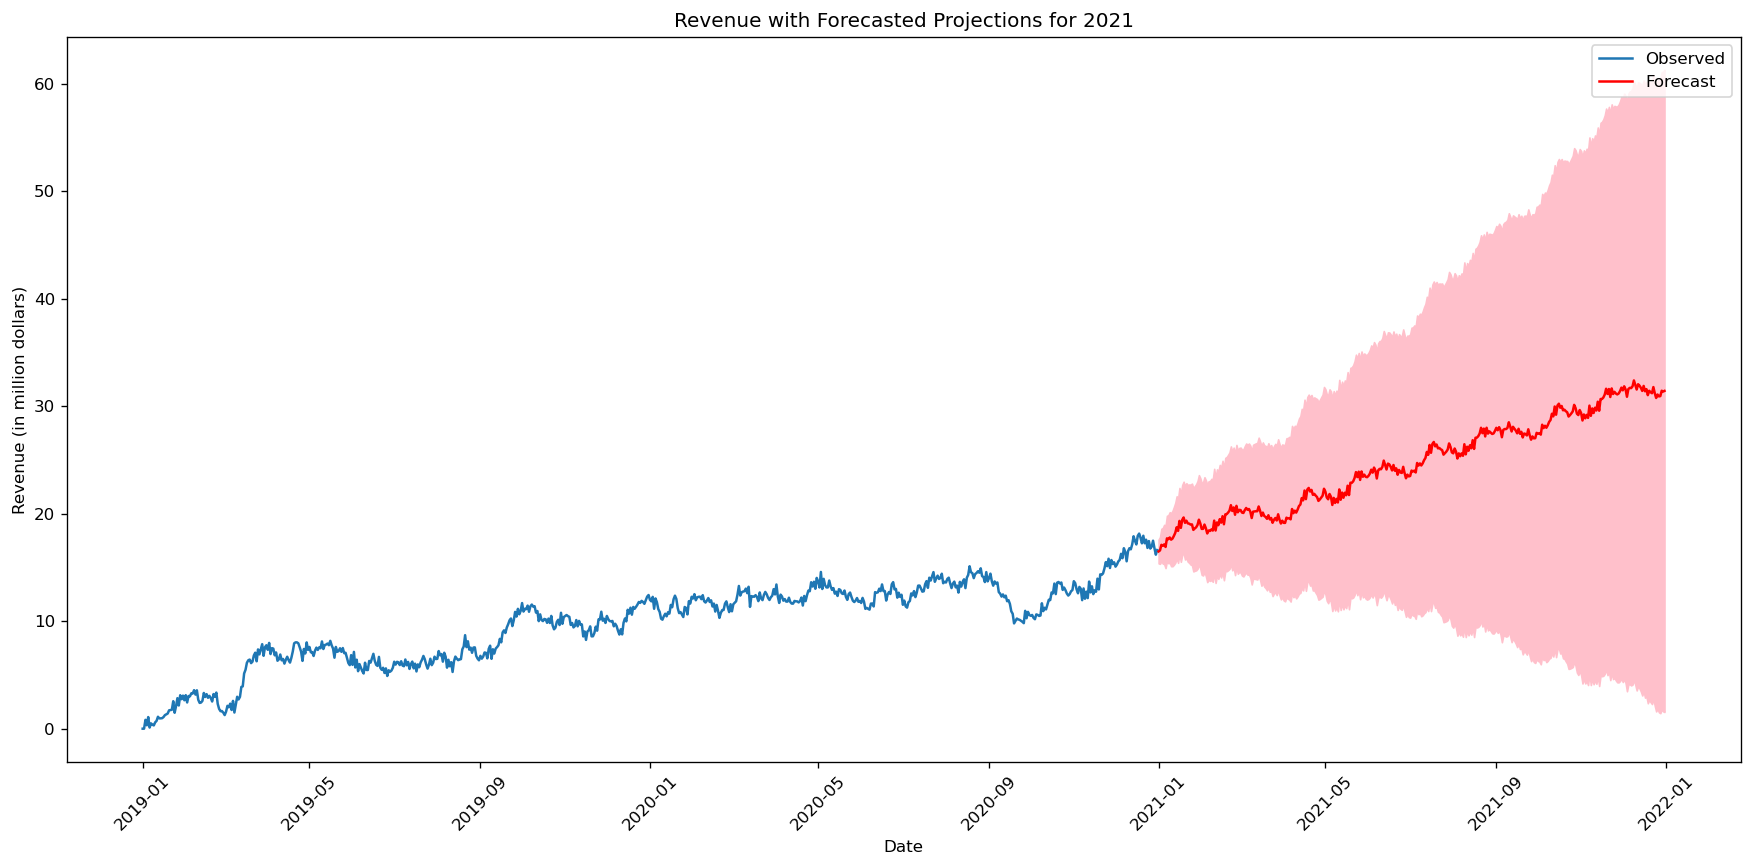

In [134]:
#(Elleh, 2022)
#Plot Forecasted Revenue Data 
plt.plot(df.index, df, label='Observed')

#Plot mean predications
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Forecast')

#Shade area between confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

#Set labels, legend, and show plot 
plt.title('Revenue with Forecasted Projections for 2021')
plt.xlabel('Date')
plt.ylabel('Revenue (in million dollars)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Revenue projection for the year 2021'}, xlabel='Date', ylabel='Revenue (in million dollars)'>

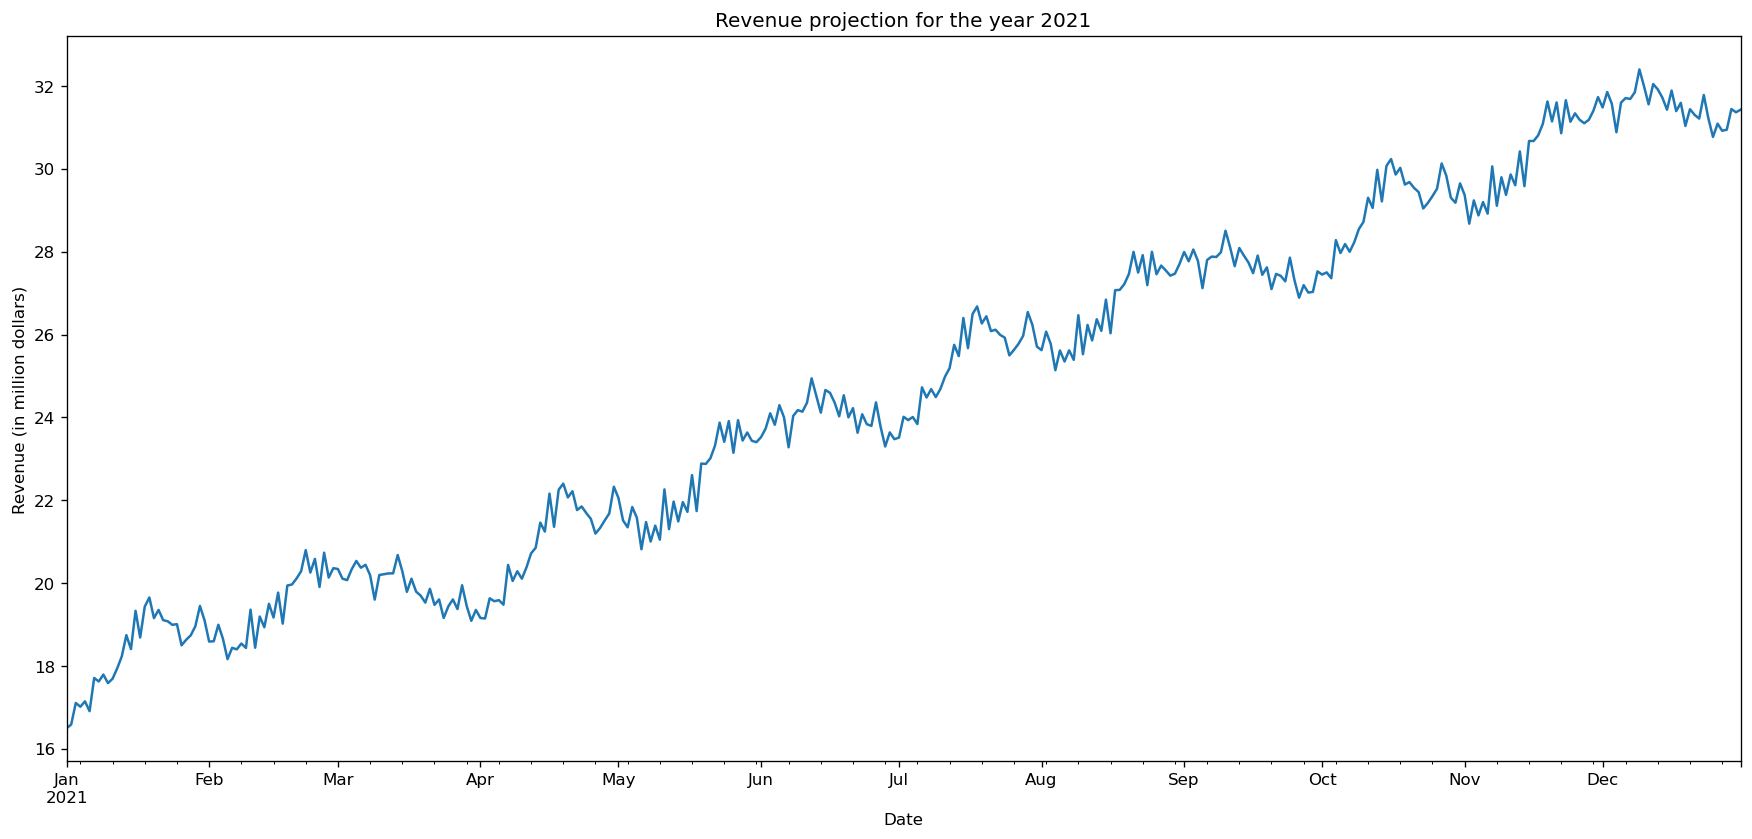

In [135]:
#(Elleh, 2022)
plt.title('Revenue projection for the year 2021')
plt.xlabel('Date')
plt.ylabel('Revenue (in million dollars)')
mean_forecast.plot()

In [136]:
#(Elleh, 2022)
#Save the model 
joblib.dump(model, '/Users/Amanda.Hartzler/Desktop/D213_TimeSeriesModel.pkl')

['/Users/Amanda.Hartzler/Desktop/D213_TimeSeriesModel.pkl']